# Build machine-learning based predictors

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [41]:
df = pd.read_csv('nbafull.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 971 entries, 0 to 970
Data columns (total 47 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                971 non-null    object 
 1   start_time          971 non-null    object 
 2   vis_team            971 non-null    object 
 3   home_team           971 non-null    object 
 4   vis_points          971 non-null    int64  
 5   home_points         971 non-null    int64  
 6   ot                  971 non-null    int64  
 7   attendance          971 non-null    int64  
 8   home_initial        971 non-null    object 
 9   vis_initial         971 non-null    object 
 10  home_players        971 non-null    object 
 11  home_bench          971 non-null    object 
 12  vis_players         971 non-null    object 
 13  vis_bench           971 non-null    object 
 14  referees            971 non-null    object 
 15  score_starter_home  971 non-null    float64
 16  score_be

Let's say we wanna predict if the final score from both team reach threshold score or not

In [39]:
def reach_thres(val, thres):
    if val >= thres: return 1
    else: return 0

df['total_score'] = df['home_points'] + df['vis_points']
df['class'] = df['total_score'].apply(reach_thres, thres=220)

Now, let's define our features:
1. Change date as fraction from beginning to end of regular season. Starting date on Oct 22. The end was originally scheduled on April 15.

In [40]:
full_season_in_days = (pd.Timestamp('2020-04-15') - pd.Timestamp('2019-10-22')).days

df['frac_season'] = (pd.to_datetime(df['date']) - pd.Timestamp('2019-10-22')).dt.days / full_season_in_days

2. Starting time in the match day. Let's do it as fraction of day. We can convert this to ordeal in the future.

In [24]:
df['day_hour'] = (pd.to_timedelta(df['start_time']) - pd.Timedelta('00:00:00')) / pd.Timedelta('1 hour')
df.to_csv('nba_h2o.csv')

3. Leave attendance as is.
4. Change home and vis initial as one-hot-encoding.

In [25]:
vis_initial  = pd.get_dummies(df['vis_initial'], prefix='vis')
home_initial = pd.get_dummies(df['home_initial'], prefix='home')

5. Still have problem with referee web scapring.

In [26]:
df = df.drop(columns=['Unnamed: 0'])

In [8]:
df['ref_1'] = df['referees'].str.split(',', expand=True)[0]
df['ref_2'] = df['referees'].str.split(',', expand=True)[1]
df['ref_3'] = df['referees'].str.split(',', expand=True)[2]

In [27]:
refs = df['referees'].str.get_dummies(sep=',')


# This is our features

In [28]:
features = ['frac_season',
            'day_hour',
            'attendance',
            'score_starter_home',
            'score_bench_home',
            'score_starter_vis',
            'score_bench_vis',
            'recovery_time',
            'perform',
            'def_perf_home',
            'off_perf_home',
            'def_perf_vis',
            'off_perf_vis']

clean_df = pd.concat([df['class'], df[features], home_initial, vis_initial,refs], axis=1)
clean_df = clean_df.dropna(axis=0, how='any')

y = clean_df['class']
X = clean_df.drop(['class'], axis=1)
X.columns

Index(['frac_season', 'day_hour', 'attendance', 'score_starter_home',
       'score_bench_home', 'score_starter_vis', 'score_bench_vis',
       'recovery_time', 'perform', 'def_perf_home',
       ...
       'Terance Mann', 'Tom Washington', 'Tony Brothers', 'Tony Brown',
       'Tre Maddox', 'Tyler Cook', 'Tyler Ford', 'Yuta Watanabe',
       'Zach Norvell', 'Zach Zarba'],
      dtype='object', length=183)

# Let's play with machine learning

In [29]:
rfc = RandomForestClassifier(random_state=101)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=101,
                       verbose=0, warm_start=False)

In [30]:
y_pred = rfc.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred)

In [31]:
confusion_matrix(y_test, y_pred)

array([[ 76,  50],
       [ 35, 110]])

In [32]:
len(y[y == 1])

498

In [33]:
len(y[y == 0])

403

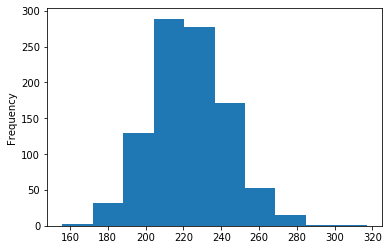

In [34]:
df['total_score'].plot(kind='hist')
plt.show()

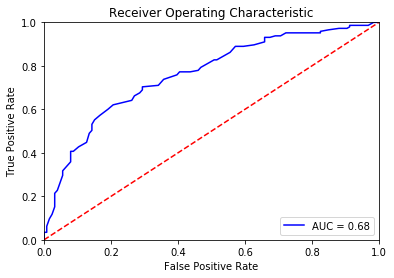

In [35]:
y_prob = rfc.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, y_prob)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [37]:
importances = rfc.feature_importances_
ind = np.argsort(importances)[::-1]
for i in ind:
    print(X.columns[i], importances[i])

off_perf_home 0.09951013204162025
def_perf_home 0.09389795428181298
def_perf_vis 0.0847039353104357
off_perf_vis 0.0771066076336224
score_bench_home 0.03900165563283392
score_bench_vis 0.03883988129433082
perform 0.03704795303242489
score_starter_vis 0.0363278593384352
frac_season 0.03391154746757223
score_starter_home 0.033649801404215945
attendance 0.03336402780937032
day_hour 0.02749418436520272
recovery_time 0.018640538638551692
Mitchell Ervin 0.006011851063700675
Derek Richardson 0.005572893571658738
Eric Lewis 0.0053946234541086425
Matt Boland 0.004690479888640945
home_BOS 0.004567954499184288
Rodney Mott 0.004548992341275482
Kevin Cutler 0.004404620346162822
David Guthrie 0.004363791949037237
Karl Lane 0.004223978990129194
Zach Zarba 0.004194004926405441
Ben Taylor 0.004114173071176507
Marat Kogut 0.003994358329767529
home_CHO 0.003976104590151413
Mark Lindsay 0.003974642269592103
James Williams 0.0038813105066375937
Curtis Blair 0.0037735155340140806
John Goble 0.00374610621145

# Looks like a good starting point. Move on to CV for hyperparameter tuning

These are the parameters to vary in random forest classifier:
1. n_estimators : number of tree in the forest
2. criterion : loss metric (gini or entropy)
3. max_depth : maximum depth (in node layers) of a tree
4. min_samples_split : minimum number of sample required to split in a node (can be a fraction of sample)
5. min_samples_leaf : minimum number of sample required at a node (can be a fraction)
6. max_features : number of features to consider (float, sqrt, log2)
7. bootstrap : True or False
8. oob_score : True or False
9. ccp_alpha : complexity parameter for pruning the tree. See this as penalty term

There are many of them. Start with small number and count the computing time

In [18]:
parameters = {'criterion': ('gini', 'entropy'), \
              'min_samples_split': [2, 0.01, 0.05], \
              'max_features': ('sqrt', 'log2', 0.5), \
              'ccp_alpha': [0, 1, 10]}

In [19]:
rfc = RandomForestClassifier(random_state=101)
clf = GridSearchCV(rfc, parameters)

In [20]:
#%%time
#clf.fit(X_train, y_train)

In [21]:
#clf.best_params_

In [22]:
#clf.best_score_

# Let's do it with H2O

In [57]:
import h2o
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid import H2OGridSearch

In [58]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 hour 33 mins
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.3
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_dyas_hqg8z1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.215 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [47]:
df = h2o.import_file('nba_h2o.csv')

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [48]:
df.columns

['C1',
 'Unnamed: 0',
 'date',
 'start_time',
 'vis_team',
 'home_team',
 'vis_points',
 'home_points',
 'ot',
 'attendance',
 'home_initial',
 'vis_initial',
 'home_players',
 'home_bench',
 'vis_players',
 'vis_bench',
 'referees',
 'score_starter_home',
 'score_bench_home',
 'score_starter_vis',
 'score_bench_vis',
 'recovery_time',
 'perform',
 'def_perf_home',
 'off_perf_home',
 'def_perf_vis',
 'off_perf_vis',
 'total_score',
 'class',
 'frac_season',
 'day_hour']

In [49]:
feature_cols = ['frac_season',
            'day_hour',
            'attendance',
            'score_starter_home',
            'score_bench_home',
            'score_starter_vis',
            'score_bench_vis',
            'recovery_time',
            'perform',
            'def_perf_home',
            'off_perf_home',
            'def_perf_vis',
            'off_perf_vis',
            'home_initial',
            'vis_initial']

response_col = 'class'

In [50]:
df['home_initial'] = df['home_initial'].asfactor()
df['vis_initial']  = df['vis_initial'].asfactor()
df['class'] = df['class'].asfactor()

In [51]:
train, test = df.split_frame(ratios=[0.7])

In [52]:
model = H2ORandomForestEstimator(ntrees=50, max_depth=20, nfolds=10, balance_classes=True)
model.train(x=feature_cols, y=response_col, training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [53]:
performance = model.model_performance(test_data=test)
performance


ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.19221721179236687
RMSE: 0.4384258338560433
LogLoss: 0.5755465054063524
Mean Per-Class Error: 0.2734685195689166
AUC: 0.7802278313480809
AUCPR: 0.8057055204279683
Gini: 0.5604556626961619

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.52: 


,,0,1,Error,Rate
0,0,80.0,49.0,0.3798,(49.0/129.0)
1,1,32.0,132.0,0.1951,(32.0/164.0)
2,Total,112.0,181.0,0.2765,(81.0/293.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.52,0.765217,32.0
1,max f2,0.14,0.866100,54.0
2,max f0point5,0.64,0.774540,23.0
3,max accuracy,0.54,0.726962,31.0
4,max precision,1.00,1.000000,0.0
5,max recall,0.04,1.000000,57.0
6,max specificity,1.00,1.000000,0.0
7,max absolute_mcc,0.64,0.456244,23.0
8,max min_per_class_accuracy,0.56,0.705426,30.0
9,max mean_per_class_accuracy,0.64,0.726531,23.0



Gains/Lift Table: Avg response rate: 55.97 %, avg score: 56.80 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010239,0.9816,1.786585,1.786585,1.000000,1.000000,1.000000,1.000000,0.018293,0.018293,78.658537,78.658537
1,,2,0.023891,0.9800,1.339939,1.531359,0.750000,0.980000,0.857143,0.988571,0.018293,0.036585,33.993902,53.135889
2,,3,0.034130,0.9600,1.191057,1.429268,0.666667,0.960000,0.800000,0.980000,0.012195,0.048780,19.105691,42.926829
3,,4,0.047782,0.9400,1.786585,1.531359,1.000000,0.940000,0.857143,0.968571,0.024390,0.073171,78.658537,53.135889
4,,5,0.051195,0.9210,1.786585,1.548374,1.000000,0.922500,0.866667,0.965500,0.006098,0.079268,78.658537,54.837398
5,,6,0.105802,0.8800,1.563262,1.556058,0.875000,0.897500,0.870968,0.930403,0.085366,0.164634,56.326220,55.605822
6,,7,0.163823,0.8400,1.576399,1.563262,0.882353,0.851691,0.875000,0.902526,0.091463,0.256098,57.639885,56.326220
7,,8,0.218430,0.8000,1.563262,1.563262,0.875000,0.812422,0.875000,0.880000,0.085366,0.341463,56.326220,56.326220
8,,9,0.313993,0.7200,1.531359,1.553552,0.857143,0.750893,0.869565,0.840707,0.146341,0.487805,53.135889,55.355249
9,,10,0.416382,0.6400,1.250610,1.479058,0.700000,0.670000,0.827869,0.798730,0.128049,0.615854,25.060976,47.905838


In [67]:
hyper_parameters = {'categorical_encoding': ['auto', 'one_hot_internal', 'label_encoder'],
                    'max_depth': [10, 20, 30],
                    'ntrees': [30, 50, 70]}

rfc = H2ORandomForestEstimator(nfolds=3, balance_classes=True)

gs = H2OGridSearch(rfc, hyper_parameters)

In [68]:
gs.train(x=feature_cols, y=response_col, training_frame=train)

drf Grid Build progress: |████████████████████████████████████████████████| 100%
Errors/Warnings building gridsearch model

Hyper-parameter: categorical_encoding, OneHotInternal
Hyper-parameter: max_depth, 20
Hyper-parameter: ntrees, 50
failure_details: Illegal argument(s) for DRF model: Grid_DRF_py_14_sid_a1f4_model_python_1589658283860_9901_model_14.  Details: ERRR on field: _categorical_encoding: Cannot use OneHotInternal categorical encoding for tree methods.
ERRR on field: _categorical_encoding: Cannot use OneHotInternal categorical encoding for tree methods.
ERRR on field: _categorical_encoding: Cannot use OneHotInternal categorical encoding for tree methods.
ERRR on field: _categorical_encoding: Cannot use OneHotInternal categorical encoding for tree methods.

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for DRF model: Grid_DRF_py_14_sid_a1f4_model_python_1589658283860_9901_model_14.  Details: ERRR on field: _categorical_enc


Hyper-parameter: categorical_encoding, OneHotInternal
Hyper-parameter: max_depth, 10
Hyper-parameter: ntrees, 70
failure_details: Illegal argument(s) for DRF model: Grid_DRF_py_14_sid_a1f4_model_python_1589658283860_9901_model_20.  Details: ERRR on field: _categorical_encoding: Cannot use OneHotInternal categorical encoding for tree methods.
ERRR on field: _categorical_encoding: Cannot use OneHotInternal categorical encoding for tree methods.
ERRR on field: _categorical_encoding: Cannot use OneHotInternal categorical encoding for tree methods.
ERRR on field: _categorical_encoding: Cannot use OneHotInternal categorical encoding for tree methods.

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for DRF model: Grid_DRF_py_14_sid_a1f4_model_python_1589658283860_9901_model_20.  Details: ERRR on field: _categorical_encoding: Cannot use OneHotInternal categorical encoding for tree methods.
ERRR on field: _categorical_encoding: Cannot use On


Hyper-parameter: categorical_encoding, OneHotInternal
Hyper-parameter: max_depth, 30
Hyper-parameter: ntrees, 70
failure_details: Illegal argument(s) for DRF model: Grid_DRF_py_14_sid_a1f4_model_python_1589658283860_9901_model_26.  Details: ERRR on field: _categorical_encoding: Cannot use OneHotInternal categorical encoding for tree methods.
ERRR on field: _categorical_encoding: Cannot use OneHotInternal categorical encoding for tree methods.
ERRR on field: _categorical_encoding: Cannot use OneHotInternal categorical encoding for tree methods.
ERRR on field: _categorical_encoding: Cannot use OneHotInternal categorical encoding for tree methods.

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for DRF model: Grid_DRF_py_14_sid_a1f4_model_python_1589658283860_9901_model_26.  Details: ERRR on field: _categorical_encoding: Cannot use OneHotInternal categorical encoding for tree methods.
ERRR on field: _categorical_encoding: Cannot use On

In [69]:
gs.show()

     categorical_encoding max_depth ntrees  \
0            LabelEncoder        10     70   
1                    AUTO        10     70   
2            LabelEncoder        20     70   
3                    AUTO        20     70   
4            LabelEncoder        10     30   
5            LabelEncoder        30     50   
6            LabelEncoder        10     50   
7            LabelEncoder        30     30   
8                    AUTO        30     70   
9                    AUTO        20     50   
10           LabelEncoder        30     70   
11           LabelEncoder        20     30   
12           LabelEncoder        20     50   
13                   AUTO        20     30   
14                   AUTO        30     30   
15                   AUTO        30     50   
16                   AUTO        10     50   
17                   AUTO        10     30   

                                                           model_ids  \
0   Grid_DRF_py_14_sid_a1f4_model_python_158965828386

In [71]:
gs_perf = gs.get_grid(sort_by='auc', decreasing=True)
gs_perf
best_gs = gs_perf.models[0]

In [42]:
best_gs_perf = best_gs.model_performance(test)
best_gs_perf.auc()

NameError: name 'best_gs' is not defined